# Tessa Vu
### MUSA 6950
### Dr. Li

# ASSIGNMENT 3: DEM AND HAND MODELING FOR PENNSYLVANIA
#### Download DEM in Pennsylvania and run HAND model.

- Download DEM tiles for Pennsylvania.
- Run HAND model to estimate inudation depth for each tile.
- Export results to geotiff.
- Mosaic exposed results into complete `geotiff` for Pennsylvania.
- Upload your notebook and submit a report to present your map for PA.

### DOWNLOAD 1-ARC-SECOND (~30 METER) DEM FOR PENNSYLVANIA

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.font_manager import FontProperties
import geopandas as gpd
import fiona
import numpy as np
import os
from pysheds.grid import Grid
import pysheds
import rasterio as rio
from rasterio.transform import from_origin
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import Window
from rasterio.warp import calculate_default_transform, reproject, Resampling
import requests

In [ ]:
def get_tile_name(lat, lon):
    """
    Returns the USGS tile name formatted correctly (e.g., "n39w076").
    """
    # Determine latitude and longitude tile names.
    lat_tile = f"n{int(abs(lat)):02d}" if lat >= 0 else f"s{int(abs(lat)):02d}" # Latitude is equal to 0 or positive.
    lon_tile = f"w{int(abs(lon)):03d}" if lon < 0 else f"e{int(abs(lon)):03d}" # Longitude is negative.

    return f"{lat_tile}{lon_tile}"

In [ ]:
def get_tiles_in_bbox(min_lat, max_lat, min_lon, max_lon):
    """
    Returns a list of tile names covering a bounding box.
    """
    # Generate list of tile names.
    tile_list = []

    # Loop through latitude and longitude ranges to get all tiles.
    for lat in range(int(min_lat), int(max_lat) + 1):
        for lon in range(int(min_lon), int(max_lon) + 1):
            # Append tile name to list.
            tile_list.append(get_tile_name(lat, lon))
            
    return tile_list

In [ ]:
# Get tiles for the entirety of Pennsylvania.
tiles = get_tiles_in_bbox(40, 43, -81, -75)

# Print check.
print("Tiles to Download:", tiles)

Tiles to Download: ['n40w081', 'n40w080', 'n40w079', 'n40w078', 'n40w077', 'n40w076', 'n40w075', 'n41w081', 'n41w080', 'n41w079', 'n41w078', 'n41w077', 'n41w076', 'n41w075', 'n42w081', 'n42w080', 'n42w079', 'n42w078', 'n42w077', 'n42w076', 'n42w075', 'n43w081', 'n43w080', 'n43w079', 'n43w078', 'n43w077', 'n43w076', 'n43w075']


In [ ]:
def download_dem_1arc(tile_name, save_path = "."):
    """
    Downloads a 1-arc-second (~30m) DEM tile from USGS TNM.
    
    Parameters:
        tile_name (str): Tile name (e.g., "n39w076").
        save_path (str): Directory to save the DEM file.
    """
    # Provide URL for download.
    base_url = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/current"
    # Construct full URL.
    url = f"{base_url}/{tile_name}/USGS_1_{tile_name}.tif"
    
    # Define output file path.
    output_file = os.path.join(save_path, f"{tile_name}.tif")
    
    # Download the file.
    response = requests.get(url, stream = True)

    # Check if the request was successful.
    if response.status_code == 200:
        # Write the content to a file.
        with open(output_file, "wb") as file:
            # Write in chunks to handle large files.
            for chunk in response.iter_content(1024):
                file.write(chunk)
        # Print checks.
        print(f"✅ DEM Tile {tile_name} downloaded.")
    else:
        print(f"❌ Error: Tile {tile_name} not found. Check availability.")
        print(url)

# Download multiple tiles.
save_directory = "DEM_Tiles"

# Create folder if it doesn't exist.
os.makedirs(save_directory, exist_ok = True)

# Loop through tiles and download each.
for tile in tiles:
    download_dem_1arc(tile, save_directory)

✅ DEM Tile n40w081 downloaded successfully!
✅ DEM Tile n40w080 downloaded successfully!
✅ DEM Tile n40w079 downloaded successfully!
✅ DEM Tile n40w078 downloaded successfully!
✅ DEM Tile n40w077 downloaded successfully!
✅ DEM Tile n40w076 downloaded successfully!
✅ DEM Tile n40w075 downloaded successfully!
✅ DEM Tile n41w081 downloaded successfully!
✅ DEM Tile n41w080 downloaded successfully!
✅ DEM Tile n41w079 downloaded successfully!
✅ DEM Tile n41w078 downloaded successfully!
✅ DEM Tile n41w077 downloaded successfully!
✅ DEM Tile n41w076 downloaded successfully!
✅ DEM Tile n41w075 downloaded successfully!
✅ DEM Tile n42w081 downloaded successfully!
✅ DEM Tile n42w080 downloaded successfully!
✅ DEM Tile n42w079 downloaded successfully!
✅ DEM Tile n42w078 downloaded successfully!
✅ DEM Tile n42w077 downloaded successfully!
✅ DEM Tile n42w076 downloaded successfully!
✅ DEM Tile n42w075 downloaded successfully!
✅ DEM Tile n43w081 downloaded successfully!
✅ DEM Tile n43w080 downloaded su

### CALCULATE HEIGHT ABOVE NEAREST DRAINAGE (HAND) AND INUNDATION DEPTHS

In [ ]:
# CODE CHUNK RUN TIME: ~44 MINUTES.

# Process DEM tiles to estimate inundation extent.
input_folder = "DEM_Tiles"
output_folder = "Inundation_Results"

# Create output folder if it doesn't exist.
os.makedirs(output_folder, exist_ok = True)

# Loop through each .tif file in the input folder.
for dem_file in os.listdir(input_folder):
    if not dem_file.endswith(".tif"):
        continue

    # Path to DEM file.
    dem_path = os.path.join(input_folder, dem_file)
    print(f"File: {dem_file}")

    # Read raw DEM.
    grid = Grid.from_raster(dem_path) # Load DEM.
    dem = grid.read_raster(dem_path) # Read as numpy array.

    # Fill pits.
    pits = grid.detect_pits(dem) # Detect pits.
    filled_pits_dem = grid.fill_pits(dem) # Fill pits.
    pits = grid.detect_pits(filled_pits_dem) # Re-detect pits.

    # Create warning if any pits remain. Assert is too strict and causes an error.
    if pits.any():
        print("WARNING: Some pits remain.")

    # Detect depressions.
    depressions = grid.detect_depressions(filled_pits_dem) # Detect depressions.
    flooded_dem = grid.fill_depressions(filled_pits_dem) # Fill depressions.
    depressions = grid.detect_depressions(flooded_dem) # Re-detect depressions.

    # Create warning if any depressions remain. Assert is too strict and causes an error.
    if depressions.any():
        print("WARNING: Some depressions remain.")

    # Resolve flats.
    inflated_dem = grid.resolve_flats(flooded_dem) # Resolve flats.
    flats = grid.detect_flats(inflated_dem) # Detect flats.

    # Compute flow direction based on corrected DEM.
    flow_direction = grid.flowdir(inflated_dem)

    # Compute flow accumulation based on computed flow direction.
    flow_accumulation = grid.accumulation(flow_direction)

    # Compute Height Above Nearest Drainage (HAND).
    hand = grid.compute_hand(flow_direction, dem, flow_accumulation > 200)

    # Estimate inundation extent (constant channel depth).
    threshold = 5 # Meters.
    inundation_extent = np.where(hand < threshold, threshold - hand, np.nan) # Areas below threshold are inundated.

    # Export inundation GeoTIFF raster to output folder.
    output_name = f"inundation_{dem_file}"
    output_path = os.path.join(output_folder, output_name)

    # Save inundation extent as GeoTIFF.
    with rio.open(dem_path) as src:
        metadata = src.meta.copy() # Copy metadata from source DEM.
        metadata.update(dtype = rio.float32, count = 1, compress = "lzw") # Update metadata, set data type to float32, single band, and apply compression.

        # Write the inundation extent to a new file.
        with rio.open(output_path, "w", **metadata) as destination:
            destination.write(inundation_extent.astype(rio.float32), 1) # Write as float32.

    # Print check.
    print(f"✅ Saved: {output_name}")

# Final check.
print("✅ Yippee!")

File: n40w075.tif
✅ Saved: inundation_n40w075.tif
File: n40w076.tif
✅ Saved: inundation_n40w076.tif
File: n40w077.tif
✅ Saved: inundation_n40w077.tif
File: n40w078.tif
✅ Saved: inundation_n40w078.tif
File: n40w079.tif
✅ Saved: inundation_n40w079.tif
File: n40w080.tif
✅ Saved: inundation_n40w080.tif
File: n40w081.tif
✅ Saved: inundation_n40w081.tif
File: n41w075.tif
✅ Saved: inundation_n41w075.tif
File: n41w076.tif
✅ Saved: inundation_n41w076.tif
File: n41w077.tif
✅ Saved: inundation_n41w077.tif
File: n41w078.tif
✅ Saved: inundation_n41w078.tif
File: n41w079.tif
✅ Saved: inundation_n41w079.tif
File: n41w080.tif
✅ Saved: inundation_n41w080.tif
File: n41w081.tif
✅ Saved: inundation_n41w081.tif
File: n42w075.tif
✅ Saved: inundation_n42w075.tif
File: n42w076.tif
✅ Saved: inundation_n42w076.tif
File: n42w077.tif
✅ Saved: inundation_n42w077.tif
File: n42w078.tif
✅ Saved: inundation_n42w078.tif
File: n42w079.tif
✅ Saved: inundation_n42w079.tif
File: n42w080.tif
✅ Saved: inundation_n42w080.tif


### MOSAIC INUNDATION TILES

In [ ]:
# CODE CHUNK RUN TIME: ~5 MINUTES.

# Declare inputs in folder with NAIP tif files.
in_folder = "Inundation_Results"
# Declare output tif file in data folder.
out_file = "Inundation_Mosaic.tif"

# Create empty list to hold tif file paths.
tif_list = []

# Loop through each tif file in Inundation_Results folder and append the file to list.
for file in os.listdir(in_folder):    
    if file.endswith(".tif"): # Only consider .tif files.
        tif_file = os.path.join(in_folder, file) # Full path to tif file.
        tif_list.append(tif_file) # Append to list.

# Create empty list to hold rasterio objects.
src_files_to_mosaic = []

# Open raster tiles and check bounds, then append to mosaic list.
for tif_path in tif_list: # Loop through each tif file path.
    try:
        tile_src = rio.open(tif_path) # Open the tif file.
        tile_bounds = tile_src.bounds # Get the bounds of the tile.
        
        src_files_to_mosaic.append(tile_src) # Append the rasterio object to the list.
    except:
        continue

# Print number of tiles valid for mosaicking.
print("Number of mosaicked tiles is:", len(src_files_to_mosaic))

# Mosaick tiles and print to check.
mosaic, out_trans = merge(src_files_to_mosaic)
print("✅ Mosaicked!")

# Prepare schema of the output mosaicked image.
out_meta = tile_src.meta.copy()
out_meta.update({"driver": "GTiff", # Output formate is GeoTIFF.
                  "height": mosaic.shape[1], # Array height.
                  "width": mosaic.shape[2], # Array width.
                  "transform": out_trans, # Transformed variable from mosaicking.
                  "compress": "lzw", # Compression to save space, no loss of data.
                  "BIGTIFF": "YES" # Accommodate very large tif files.
                  }
               )

# Open and write the output file metadata for the mosaic.
with rio.open(out_file, "w", **out_meta) as dest:
     dest.write(mosaic) # Write the mosaic array.

# mosaicked tiles is: 28
Results mosaicked.


### REPROJECT INUNDATION GEOTIFF CRS

In [ ]:
# Declare input tif file.
og_tif_path = "Inundation_Mosaic.tif"

# Declare output tif file.
final_tif_path = "Inundation_Mosaic_Reprojected.tif"

# Reprojection EPSG to Web Mercator.
new_crs = "EPSG:3857"

# Reproject the raster.
with rio.open(og_tif_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, new_crs, src.width, src.height, *src.bounds
    )

In [ ]:
# Update the metadata.
with rio.open(og_tif_path) as src:
    profile = src.profile
    profile.update(
        crs = new_crs,
        transform = transform,
        width = width,
        height = height
    )

    # Write the reprojected raster to a new file.
    with rio.open(final_tif_path, "w", **profile) as dest:
        for pixel in range(1, src.count + 1):
            reproject(
                source = rio.band(src, pixel),
                destination = rio.band(dest, pixel),
                src_transform = src.transform,
                src_crs = src.crs,
                dst_transform = transform,
                dst_crs = new_crs,
                resampling = Resampling.nearest
            )

### MASK INUNDATION GEOTIFF TO STATE OF PENNSYLVANIA

In [ ]:
# Rasters to input before clipping.
in_raster = "Inundation_Mosaic_Reprojected.tif"
# Shapefile used for clipping shape. Pennsylvania state boundary.
pa_boundary_path = "data/pa_boundary_3857/pa_boundary_3857.shp"
# Clipped raster file.
out_raster = "Inundation_Mosaic_Clipped.tif"

# Open shapefile and store geometry features into shapes variable.
with fiona.open(pa_boundary_path, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

# Open raster file and transform by clipping.
with rio.open(in_raster) as src:
    # Make sure it clips the raster into the shape extent.
    out_image, out_transform = mask(src, shapes, crop = True)
    # Copy and transfer metadata over.
    out_meta = src.meta

# Output metadata.
out_meta.update({"driver": "GTiff", # GeoTIFF file type.
                 "height": out_image.shape[1], # Height array.
                 "width": out_image.shape[2], # Width array.
                 "compress": "lzw", # Compression.
                 "transform": out_transform}) # Transformation from previous code block.

# Open and write the output file metadata for the clipped raster.
with rio.open(out_raster, "w", **out_meta) as dest:
    dest.write(out_image) # Write the clipped raster array.

### PLOT INUNDATION GEOTIFF

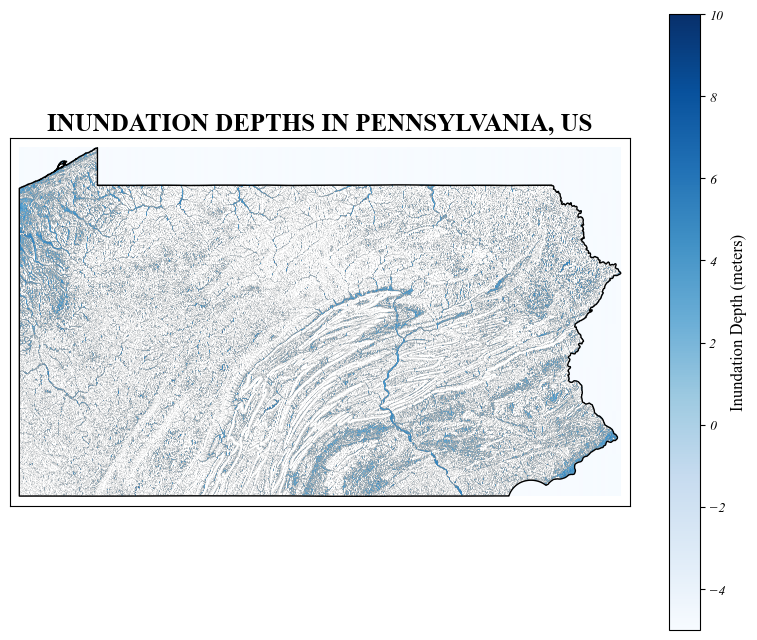

In [ ]:
# Read in Pennsylvania boundary shapefile.
pa_boundary = gpd.read_file("data/pa_boundary_3857/pa_boundary_3857.shp")

with rio.open(out_raster) as src:
    # Establish extent.
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    # Set font to Times New Roman.
    mpl.rcParams["font.serif"] = "Times New Roman"

    # Plot inundation raster.
    fig, ax = plt.subplots(figsize = (10, 8))

    # Show the raster with a blue color map.
    im = ax.imshow(src.read(1), extent = extent, cmap = "Blues", vmin = -5, vmax = 10)

    # Set axis limits with some padding so it doesn't feel too tight, and remove axis ticks.
    ax.set_xlim(src.bounds.left - 10000, src.bounds.right + 10000)
    ax.set_ylim(src.bounds.bottom - 10000, src.bounds.top + 10000)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    # Plot Pennsylvania boundary on top of raster for reference.
    pa_boundary.plot(ax = ax, facecolor = "none", edgecolor = "black", linewidth = 1)
    # Add grid for reference.
    plt.grid(True)

    # Add color bar.
    color_bar = plt.colorbar(im, ax = ax)
    # Customize color bar texts.
    color_bar.set_label(label = "Inundation Depth (meters)", size = 12)

    # Customize color bar tick labels to be italic and size 10.
    for label in color_bar.ax.get_yticklabels():
        label.set_fontstyle("italic")
        label.set_fontsize(10)
    
    # Add title with customizations.
    plt.title("INUNDATION DEPTHS IN PENNSYLVANIA, US", size = 18, fontweight = "bold")

plt.show()